<h1>Mid-Term - Part 2</h1>


In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.spatial

<h2>Data loading</h2>

In [9]:
Xtr = np.load("./Training/training_X.npy", mmap_mode=None)
Ytr = np.load("./Training/training_Y.npy", mmap_mode=None)

print(f"Shape of Xtr: {Xtr.shape}\nShape of Ytr: {Ytr.shape}\nValues of Ytr: {np.unique(Ytr)}")

Shape of Xtr: (5200, 11)
Shape of Ytr: (5200, 1)
Values of Ytr: [3 4 5 6 7 8 9]


By looking at the values of $Ytr$ we can conclude that this is a regression problem.

<h2>KRLS functions</h2>

In [10]:
def calc_err(Ypred, Ytrue):
    return np.mean((Ypred-Ytrue)**2)

def squared_distances(X1, X2):
    return scipy.spatial.distance.cdist(X1, X2, metric='seuclidean')

def kernel_matrix(X1, X2, lengthscale):
    return np.exp(-squared_distances(X1, X2) / (2 * (lengthscale**2)))

def krls_train(x, y, reg_par, kernel_par):
    w = np.linalg.solve(kernel_matrix(x, x, kernel_par) + reg_par * x.shape[0] * np.eye(x.shape[0]), y)
    return w

def krls_predict(x_ts, x_tr, w, kernel_par):
    return kernel_matrix(x_ts, x_tr, kernel_par) @ w

def krls_kfold_valerr(x_tr, y_tr, num_folds, reg_par, kernel_par):
    if num_folds <= 1:
        raise Exception("Please supply a number of folds > 1")

    n_tot = x_tr.shape[0]
    n_val = int(n_tot // num_folds)
    
    tr_errs, val_errs = [], []
    rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
    split_idx = np.array_split(rand_idx, num_folds)
    for fold in range(num_folds):
        val_mask = np.zeros(n_tot, dtype=bool)
        val_mask[split_idx[fold]] = True
        
        kf_x_tr = x_tr[~val_mask]
        kf_y_tr = y_tr[~val_mask]
        kf_x_val = x_tr[val_mask]
        kf_y_val = y_tr[val_mask]
        
        w_krls = krls_train(kf_x_tr, kf_y_tr, reg_par=reg_par, kernel_par=kernel_par)
        
        pred_tr = krls_predict(kf_x_tr, kf_x_tr, w_krls, kernel_par=kernel_par)
        pred_val = krls_predict(kf_x_val, kf_x_tr, w_krls, kernel_par=kernel_par)
        tr_errs.append(calc_err(pred_tr, kf_y_tr))
        val_errs.append(calc_err(pred_val, kf_y_val))
    return np.asarray(tr_errs), np.asarray(val_errs)

def krls_kfoldcv(x_tr, y_tr, num_folds, reg_par_list, kernel_par_list):
    errors = np.zeros((len(reg_par_list), len(kernel_par_list)))
    for i, reg_par in enumerate(reg_par_list):
        for j, kernel_par in enumerate(kernel_par_list):
            tr_error, val_error = krls_kfold_valerr(x_tr, y_tr, num_folds, reg_par, kernel_par)
            errors[i][j] = np.mean(val_error)
            
    best_reg_par = reg_par_list[np.unravel_index(np.argmin(errors), errors.shape)[0]]
    best_kernel_par = kernel_par_list[np.unravel_index(np.argmin(errors), errors.shape)[1]]
    best_err = np.min(errors)
    print(f"The best error (MSE={best_err*100:.2f}%) was obtained with "
          f"lambda={best_reg_par}, kernel-parameter={best_kernel_par}")
    return best_reg_par, best_kernel_par, best_err

<h3>Implementation</h3>

The best error (MSE=49.15%) was obtained with lambda=0.001, kernel-parameter=2.06913808111479


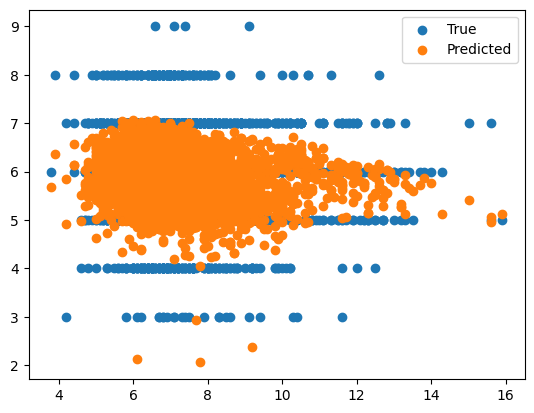

In [11]:
num_folds = 5
reg_par_list = np.logspace(-3, 3, 10)
kernel_par_list = np.logspace(-2, 2, 20)

best_reg_par, best_kernel_par, best_err = krls_kfoldcv(Xtr, Ytr, num_folds, reg_par_list, kernel_par_list)
w = krls_train(Xtr, Ytr, best_reg_par, best_kernel_par)
pred_tr = krls_predict(Xtr, Xtr, w, best_kernel_par)

plt.scatter(Xtr[:, 0], Ytr, label="True")
plt.scatter(Xtr[:, 0], pred_tr, label="Predicted")
plt.legend(loc="best");

The MSE of $49.15\%$ indicates that the predictions deviate significantly from the true values.
<br>
The $lambda$ is small, so we have a situation of overfitting.
<br>
As we can see from the plot, the predicted values are forming a cluster in the centre, where there are more true values.


<h2>Evaluation of the model</h2>

In [ ]:
Xte = np.load("...", mmap_mode=None)
Yte = np.load("...", mmap_mode=None)

w = krls_train(Xte, Yte, best_reg_par, best_kernel_par)
Ypred = krls_predict(Xte, Xtr, w, best_kernel_par)
test_err = calc_err(Ypred, Yte)

print(f"The test error is {test_err:.3f}")